In [1]:
import numpy as np
import random
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class WrightFisher():
    """
    Haploid Wright-Fisher model
    
    Parameters:
    N: population size
    s: selection coefficient
    n: initial variant allele count
    """
    def __init__(self, N, s = 0, n = 1):
        # Set population size, selection coefficient and allele count for A
        self.N = N
        self.s = s
        self.n = n
        
        # Set initial allele frequencies
        self.p0 = self.n/self.N
        self.q0 = self.N - self.p0
        
        # Set fitnesses relative to selection
        self.wa = 1 + s
        self.wA = 1
        
    # Run Wright-Fisher simulation for a single site
    def simulateSingleSite(self, max_generations):
        # Create array of population alleles per generation
        population_alleles = np.zeros(max_generations + 1, dtype = int)
        # Set allele counts for initial generation
        population_alleles[0] = self.n
        
        # Initialise counters
        gen = 0
        allele_count = self.n
        max_allele_counts = self.n
        
        # Repeat for n generations
        while (gen < max_generations and 0 < allele_count < self.N + 1):
            gen += 1
            
            # Get the allele count in the previous generation
            allele_count = population_alleles[gen - 1]
            # Calculate probability of sampling the allele 
            prob = allele_count * (1 + self.s) / (allele_count * (1 + self.s) + self.N - allele_count)
            
            # Simulate number of copies in next generation
            population_alleles[gen] = np.random.binomial(n = self.N,
                                                         p = prob)
        
        return population_alleles
    
    # Run Wright-Fisher simulation for two loci
    def simulateTwoSites(self, alleles, allele_counts, singleton_haploid, r):
        # Whether one loci's allele is fixed
        allele_fixed = False

        # Set initial population
        current_alleles = alleles
        new_allele_counts = allele_counts
        
        # Record the haplotype frequencies per generation
        haplotype_frequencies = np.array(list(alleles.values()))

        # Record D', D and r^2 per generation
        ld_results = self.linkageDisequilibrium(alleles, allele_counts, singleton_haploid)
        D_normalised_per_gen = ld_results["D'"]
        D_per_gen = ld_results["D"]
        r2_per_gen = ld_results["r2"]

        # Run simulation until one loci's allele is fixed
        while not allele_fixed:
            # Set new empty population
            new_alleles = {"AB": 0, "Ab": 0, "aB": 0, "ab": 0}

            # Populate the new population
            for i in range(self.N):

                # Probability of each haplotype being selected
                selection_probability = np.array(list(current_alleles.values())) / self.N
                # Add selection coefficient and normalise
                selection_probability + np.array([self.s, self.s, -self.s, -self.s])
                selection_probability = [i/sum(selection_probability)
                                         for i in selection_probability]

                # Randomly select a haplotype from the population
                individual = np.random.choice(list(current_alleles.keys()),
                                              p = selection_probability)

                # No recombination
                if np.random.uniform() > r:
                    # Offspring is the same as the individual in the next generation
                    new_alleles[individual] += 1

                # Make a recombinant haplotype
                else:
                    # Randomly select an allele to keep
                    allele_1 = np.random.choice(list(individual))

                    # If A loci, randomly select a B allele from the population
                    if allele_1.lower() == "a":
                        allele_2 = np.random.choice(["B", "b"],
                                                    p = np.array([new_allele_counts["B"],
                                                                  new_allele_counts["b"]]) / self.N)
                        # Form the new recombinant haplotype
                        offspring = allele_1 + allele_2

                    # Otherwise randomly select an A allele from the population
                    else:
                        allele_2 = np.random.choice(["A", "a"],
                                                    p = np.array([new_allele_counts["A"],
                                                                  new_allele_counts["a"]]) / self.N)
                        offspring = allele_2 + allele_1

                    # Add the recombinant offspring to the population
                    new_alleles[offspring] += 1

            # Update the new allele counts for the new population
            new_allele_counts = {"A": new_alleles["AB"] + new_alleles["Ab"],
                                 "a": new_alleles["aB"] + new_alleles["ab"],
                                 "B": new_alleles["AB"] + new_alleles["aB"],
                                 "b": new_alleles["Ab"] + new_alleles["ab"]}

            # Record D' and r^2
            ld_results = self.linkageDisequilibrium(new_alleles, new_allele_counts, singleton_haploid)
            D_normalised_per_gen = np.append(D_normalised_per_gen, ld_results["D'"])
            D_per_gen = np.append(D_per_gen, ld_results["D"])
            r2_per_gen = np.append(r2_per_gen, ld_results["r2"])
            
            # Record the haplotype frequency for the population
            haplotype_frequencies = np.vstack((haplotype_frequencies,
                                               np.array(list(new_alleles.values()))))

            # Check if any of the alleles have fixed
            if self.N in new_allele_counts.values():
                # Stop loop as an allele at a loci was lost
                allele_fixed = True
            else:
                # Set alleles for new population
                current_alleles = new_alleles
                
        return {"D'": D_normalised_per_gen, "D": D_per_gen, "r2": r2_per_gen,
                "haplotype_frequencies": np.transpose(haplotype_frequencies)}
        
    # Set population sizes for two loci simulation
    def initialiseTwoLoci(self, distribution):
        site_distribution = distribution[2:-2]
        
        # Population allele counts
        alleles = {"AB": 0, "Ab": 0, "aB": 0, "ab": 0}

        # Calculate probability of samples allele count between 2 to N - 2
        prob = site_distribution / sum(site_distribution)

        A_allele_count = np.random.choice(a = range(2, len(site_distribution) + 2), p = prob)
        a_allele_count = self.N - A_allele_count

        # Randomly introduce a singleton at a loci
        singleton_A = np.random.choice(["A", "a"])
        singleton_B = np.random.choice(["B", "b"])

        if singleton_B == "B":
            B_allele_count = 1
            b_allele_count = self.N - 1
        else:
            B_allele_count = self.N - 1
            b_allele_count = 1

        # Record the singleton
        alleles[singleton_A + singleton_B] = 1

        # Set the remaining allele counts
        if singleton_A + singleton_B == "AB":
            alleles["Ab"] = A_allele_count - 1
            alleles["aB"] = B_allele_count - alleles["AB"]
            alleles["ab"] = self.N - sum(alleles.values())

        elif singleton_A + singleton_B == "Ab":
            alleles["AB"] = A_allele_count - 1
            alleles["ab"] = b_allele_count - alleles["Ab"]
            alleles["aB"] = self.N - sum(alleles.values())

        elif singleton_A + singleton_B == "aB":
            alleles["AB"] = B_allele_count - 1
            alleles["Ab"] = A_allele_count - alleles["AB"]
            alleles["ab"] = self.N - sum(alleles.values())

        elif singleton_A + singleton_B == "ab":
            alleles["AB"] = A_allele_count
            alleles["Ab"] = b_allele_count - alleles["ab"]
            alleles["aB"] = self.N - sum(alleles.values())
            
        # Return the population genomes and allele frequencies
        return {"alleles": alleles,
                "allele_counts": {"A": A_allele_count,
                                  "a": a_allele_count,
                                  "B": B_allele_count,
                                  "b": b_allele_count},
                "singleton_haploid": singleton_A + singleton_B}
    
    # Calculate D' and r^2 LD statistics
    def linkageDisequilibrium (self, alleles, allele_counts, singleton_haploid):
        # Calculate proportion of individuals with an allele at each locus, i.e. pA, pa, pB, pb
        allele_probabilities = dict(zip(["p" + i for i in allele_counts.keys()],
                                        [allele_counts[j] / 100 for j in allele_counts.keys()]))
        # Proportion of two alleles occuring at the two loci, i.e. pAB, pAb, paB, pab
        haploid_probabilities = dict(zip(["p" + i for i in alleles.keys()],
                                         [alleles[j] / 100 for j in alleles.keys()]))

        # Calculate coefficient of linkage disequilibrium for each haplotype
        D_haplotype = {"AB": haploid_probabilities["pAB"] - (allele_probabilities["pA"] * allele_probabilities["pB"]),
                       "Ab": haploid_probabilities["pAb"] - (allele_probabilities["pA"] * allele_probabilities["pb"]),
                       "aB": haploid_probabilities["paB"] - (allele_probabilities["pa"] * allele_probabilities["pB"]),
                       "ab": haploid_probabilities["pab"] - (allele_probabilities["pa"] * allele_probabilities["pb"])}

        # Calculate normalised D by dividing by the maximum difference between observed and expected haplotype frequencies
        try:
            D_normalised = D_haplotype[singleton_haploid] / max(D_haplotype.values())
        except:
            # Prevent division by zero
            D_normalised = None

        # Calculate genetric correlation coefficient between pairs of loci
        try:
            r2 = (D_haplotype[singleton_haploid] ** 2) / (allele_probabilities["p" + singleton_haploid[0]] *
                                                          (1 - allele_probabilities["p" + singleton_haploid[0]]) *
                                                          allele_probabilities["p" + singleton_haploid[1]] *
                                                          (1 - allele_probabilities["p" + singleton_haploid[1]]))
        except:
            r2 = None
        
        return {"D'": D_normalised, "D": D_haplotype[singleton_haploid], "r2": r2}
    
    # Plot distribution of maximum allele count
    def plotMaxAllele(self, max_allele_counts,
                      title = "Distribution of Maximum Allele Number Reached ($\mathregular{M_i}$)"):
        max_allele_fig = plt.figure(figsize = (10, 5))
        max_allele_hist = plt.hist(max_allele_counts,
                                   color = "orange",
                                   edgecolor = "black", 
                                   linewidth = 1.2,
                                   bins = min(max(max_allele_counts), 100))
        plt.xlabel("Maximum Allele Number ($\mathregular{M_i}$)") 
        plt.ylabel("Number of Simulations") 
        plt.title(title)
        plt.show()
        
        return max_allele_fig
        
    # Plot distribution of time for simulations where the variant fixes or is lost
    def plotTime(self, fixation_times, loss_times, combine_plots = False,
                 title = "Distribution of Time Steps ($\mathregular{T_i}$) for the Allele to Fix or be Lost"):
        
        # Check whether to plot data on the same axis
        if combine_plots:
            time_hist_fig = plt.figure(figsize = (10, 5))
            # Plot fixation histogram
            plt.hist(fixation_times, color = "lime", label = "Fixed",
                     edgecolor = "black", linewidth = 1.2,
                     bins = 50, alpha = 0.5)
            # Also plot loss histogram on same axis
            plt.hist(loss_times, color = "red", label = "Lost",
                     edgecolor = "black", linewidth = 1.2,
                     bins = 50, alpha = 0.5)
            plt.xlabel("Time ($\mathregular{T_i}$)") 
            plt.ylabel("Number of Simulations")
            plt.title(title)
            plt.legend(loc = "upper right")
            
        # Otherwise create subplots
        else:
            time_hist_fig, axes = plt.subplots(1, 2, figsize = (12, 5))
            axes[0].hist(fixation_times, color = "lime", label = "Fixed",
                         edgecolor = "black", linewidth = 1.2,
                         bins = 50, alpha = 0.5)
            axes[1].hist(loss_times, color = "red", label = "Lost",
                         edgecolor = "black", linewidth = 1.2,
                         bins = 50, alpha = 0.5)
            axes[0].title.set_text("Fixation")
            axes[1].title.set_text("Loss")
            time_hist_fig.suptitle(title, y = 1.03)
            
            for ax in axes:
                ax.set_xlabel("Time ($\mathregular{T_i}$)")
                ax.set_ylabel("Number of Simulations")
            
        plt.show()
        
        return time_hist_fig
    
    # Plot density heatmap of allele counts over time
    def plotPathDensity(self, path_density, title = "Path Density", 
                        fontsize = 12, cmap = "viridis",
                        logscale = True, add_expected = False,
                        expected_colour = "white"):
        
        # Create figure
        density_fig, ax = plt.subplots(figsize = (11, 9))
        # Log the data if logscale set as True
        density_data = np.log(path_density + 1) if logscale else path_density
        
        # Add density heatmap of allele counts over time
        heatmap = ax.imshow(density_data, cmap = cmap, aspect = "auto")
        
        # Flip the y-axis so n increases upwards
        ax.set_ylim(ax.get_ylim()[::-1])
        
        # Add colour bar
        colour_bar = density_fig.colorbar(heatmap, pad = 0.15 if add_expected else 0.05)
        colour_bar_label = "Log(Density + 1)" if logscale else "Density"
        colour_bar.ax.set_title(colour_bar_label, fontsize = 10)

        if add_expected:
            # Create sigmoid expectation curve for p(t) under the deterministic, no drift model
            t = np.linspace(0, len(simulation_results["path_density"][0]) - 1,
                            num = len(simulation_results["path_density"][0]))
            n = 1/(1 + ((self.q0/self.p0) * ((self.wA / self.wa) ** t)))
            
            # Plot curve on top
            ax2 = plt.twinx()
            sns.lineplot(x = t, y = n, linewidth = 3, ax = ax2, color = expected_colour)
            ax.axis('tight')
            ax2.set_ylabel("Expected p(t) with no Drift", fontsize = fontsize)
        
        ax.set_xlabel("Time (t)", fontsize = fontsize)
        ax.set_ylabel("Allele Count (n)", fontsize = fontsize)
        ax.set_title(title, fontsize = fontsize + 2)
        plt.show()
        
        return density_fig
        
    # Plot distribution of number of copies of an allele over all generations
    def plotAlleleCount(self, all_allele_counts, logscale = True,
                        title = "Distribution of Total Allele Copies Across Generations S(n)"):
        allele_counts_fig = plt.figure(figsize = (10, 5))
        allele_counts_bar = plt.bar(range(len(all_allele_counts)),
                                    all_allele_counts,
                                    color = "skyblue",
                                    edgecolor = "black", 
                                    linewidth = 1.2)
        plt.xlabel("Allele Count (n)") 
        plt.ylabel("Frequency")
        plt.title(title)
        plt.yscale("log" if logscale else "linear")
        plt.show()
        
        return allele_counts_fig
    
    # Run the single site simulator n times
    def repeatSimulateSingle(self, max_generations = 500, n_times = 1000):
        # The highest numbers the allele reaches per simulation
        max_allele_counts = np.zeros(n_times, dtype = int)
        # The times taken for the allele to fix or be lost
        end_times = np.zeros(n_times, dtype = int)
        # Density of allele counts over time for n simulations
        path_density = np.zeros((self.N + 1, max_generations), dtype = int)
        
        # Total time for simulations that fix and loose the allele
        fixation_times = np.array([])
        loss_times = np.array([])
        fluctuating_times = np.array([])
        # Average time for simulations that fix and loose the allele
        mean_fixation_time = None
        mean_loss_time = None
        
        # Run the simulation n times
        for i in range(n_times):
            # Run Wright-Fisher model
            population_alleles = self.simulateSingleSite(max_generations)
            # Get the maximum allele count and simulation end time
            max_allele_counts[i] = max(population_alleles)
            end_times[i] = len(population_alleles[population_alleles != 0])
            
            # Increment path density for the new allele counts over time
            for j in range(1, len(population_alleles)):
                path_density[population_alleles[j]][j - 1] += 1
                
            # Check if allele fixes
            if population_alleles[-1] == self.N:
                # Add time when allele fixes
                fixation_times = np.append(fixation_times,
                                           np.where(population_alleles == self.N)[0][0])
            elif population_alleles[-1] == 0:
                # Add time taken for allele to be lost
                loss_times = np.append(loss_times, end_times[i])
                
        # Number of simulations in which the allele fixes, is lost or still fluctuating
        n_fixed = len(fixation_times)
        n_lost = len(loss_times)
        n_fluctuating = n_times - n_fixed - n_lost
        
        # Calculate average fixation and loss time
        if n_fixed > 0:
            mean_fixation_time = sum(fixation_times) / len(fixation_times)
        if n_lost > 0:
            mean_loss_time = sum(loss_times) / len(loss_times)
            
        # S(n) distribution, i.e. number of copies of the variant alelle over all generations
        all_allele_counts = np.array([sum(row) for row in path_density])
        
        return {"max_allele_counts": max_allele_counts,
                "end_times": end_times,
                "path_density": path_density,
                "n_fixed": n_fixed,
                "n_lost": n_lost,
                "n_fluctuating": n_fluctuating,
                "mean_fixation_time": mean_fixation_time,
                "mean_loss_time": mean_loss_time,
                "fixation_times": fixation_times,
                "loss_times": loss_times,
                "all_allele_counts": all_allele_counts}

Fixed 14 times
Lost 986 times
Fluctuating 0 times
Average fixation time of 219.286
Average loss time of 9.0


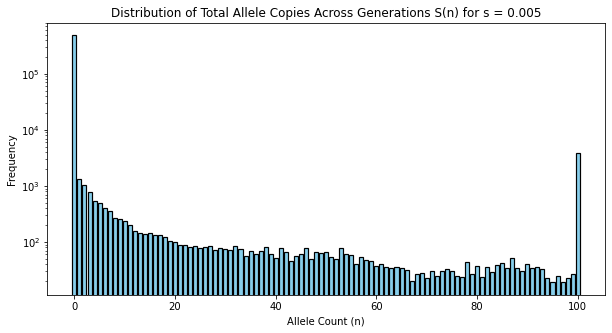

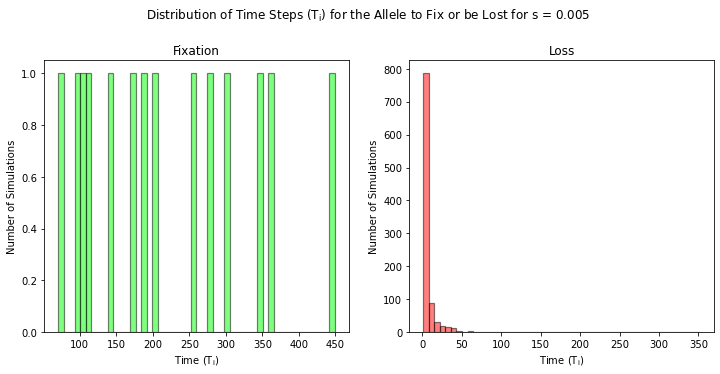

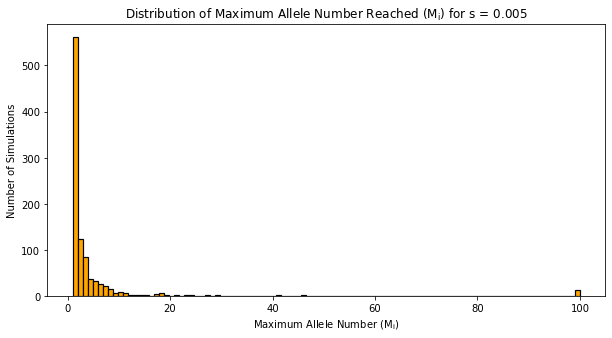

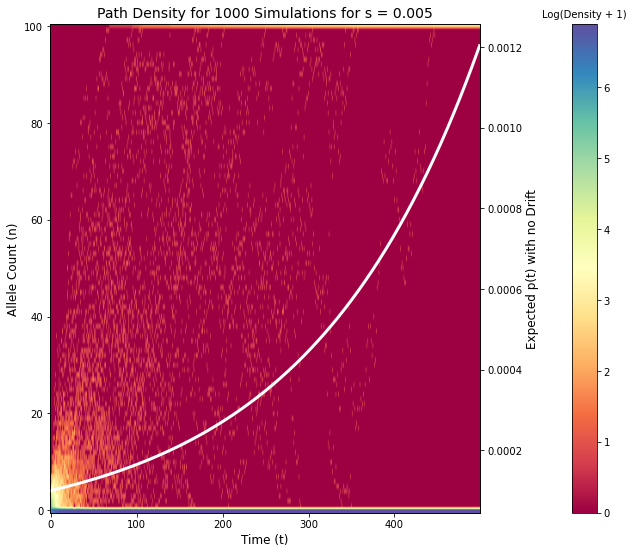

In [3]:
# Set selection coefficient s
selection_coefficient = 0.005

# Run the simulator
wf_simulator = WrightFisher(N = 100, s = selection_coefficient)
simulation_results = wf_simulator.repeatSimulateSingle(n_times = 1000)

# Print summary statistics
print("Fixed " + str(simulation_results["n_fixed"]) + " times")
print("Lost " + str(simulation_results["n_lost"]) + " times")
print("Fluctuating " + str(simulation_results["n_fluctuating"]) + " times")
if simulation_results["mean_fixation_time"] != None:
    print("Average fixation time of " + str(round(simulation_results["mean_fixation_time"], 3)))
print("Average loss time of " + str(round(simulation_results["mean_loss_time"], 3)))

# Add s to plot titles and file names if s not zero
extra_title = " for s = " + str(selection_coefficient) if selection_coefficient != 0 else ""
extra_file_name = "_s=" + str(selection_coefficient) if selection_coefficient != 0 else ""

# Plot results
allele_count_bar = wf_simulator.plotAlleleCount(simulation_results["all_allele_counts"], logscale = True,
                                               title = "Distribution of Total Allele Copies Across Generations S(n)" + extra_title)
time_bars = wf_simulator.plotTime(simulation_results["fixation_times"], simulation_results["loss_times"],
                                 title = "Distribution of Time Steps ($\mathregular{T_i}$) for the Allele to Fix or be Lost" + extra_title)
max_allele_hist = wf_simulator.plotMaxAllele(simulation_results["max_allele_counts"],
                                            title = "Distribution of Maximum Allele Number Reached ($\mathregular{M_i}$)" + extra_title)
density_plot = wf_simulator.plotPathDensity(simulation_results["path_density"], 
                                            cmap = "Spectral", logscale = True,
                                            title = "Path Density for 1000 Simulations" + extra_title,
                                            add_expected = True if selection_coefficient != 0 else False)

# Save plots
allele_count_bar.savefig("Allele_Count_Bar" + extra_file_name + ".pdf", bbox_inches = "tight")
time_bars.savefig("Time_Bars" + extra_file_name + ".pdf", bbox_inches = "tight")
max_allele_hist.savefig("Max_Allele_Histogram" + extra_file_name + ".pdf", bbox_inches = "tight")
density_plot.savefig("Path_Density" + extra_file_name + ".pdf", bbox_inches = "tight")

In [4]:
# Set new selection coefficient and recombination rate
selection_coefficient = 0.005
recombination_rate = 0.05

# Create a new simulator
wf_simulator2 = WrightFisher(N = 100, s = selection_coefficient)

In [5]:
# Set number of times to test initial distribution of D' and r^2
n_initial = 1

# Record D' and r^2 for n initial populations
initial_ld_d_norm = np.zeros(n_initial)
initial_ld_r2 = np.zeros(n_initial)

for i in range(n_initial):
    # Set initial haplotype sizes, number of AB, Ab, aB, ab
    simulation_results2 = wf_simulator.repeatSimulateSingle(n_times = 1000)
    initial_loci = wf_simulator2.initialiseTwoLoci(simulation_results2["all_allele_counts"])

    # Get allele counts and which haplotype has a count of 1
    initial_alleles = initial_loci["alleles"]
    initial_allele_counts = initial_loci["allele_counts"]
    singleton = initial_loci["singleton_haploid"]

    # Record LD measures
    ld_results = wf_simulator2.linkageDisequilibrium(initial_alleles, initial_allele_counts, singleton)
    initial_ld_d_norm[i] = ld_results["D'"]
    initial_ld_r2[i] = ld_results["r2"]
    
print("Initial alleles: " + str(initial_alleles))
print("Initial allele count: " + str(initial_allele_counts))
print("Singleton allele: " + str(singleton))

Initial alleles: {'AB': 1, 'Ab': 69, 'aB': 0, 'ab': 30}
Initial allele count: {'A': 70, 'a': 30, 'B': 1, 'b': 99}
Singleton allele: AB


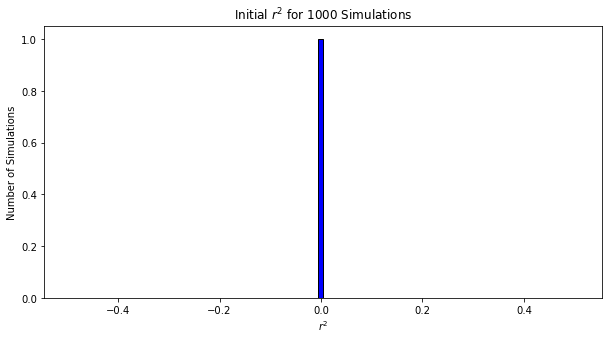

In [6]:
def plotRSquared(r2_values):
    # Plot histogram of r^2 per simulation
    fig = plt.figure(figsize = (10, 5))
    plt.hist(r2_values, color = "blue", edgecolor = "black", bins = 100)
    plt.title("Initial $r^{2}$ for 1000 Simulations")
    plt.xlabel("$r^{2}$")
    plt.ylabel("Number of Simulations")
    
    return fig

# Plot initial distribution of r^2
r2_histogram = plotRSquared(initial_ld_r2)

# Save plot
r2_histogram.savefig("r2_Initial_Distribution.pdf", bbox_inches = "tight")

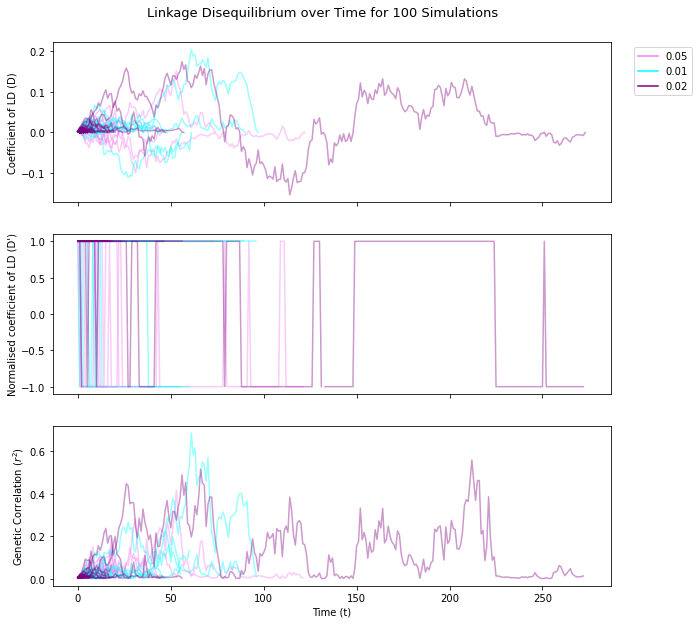

In [211]:
# Set plot styles for recombination rates to test
r_value_colours = {0.05: "violet", 0.01: "cyan", 0.02: "purple"}
r_value_linestyles = {0.05: "solid", 0.01: "solid", 0.02: "solid"}

# Number of simulations to run per r
n_simulations = 100

# Create subplots of LD over time for the recombination rates
fig, axes = plt.subplots(3, figsize = (10, 10), sharex = True)
fig.suptitle("Linkage Disequilibrium over Time for " + str(n_simulations) + " Simulations",
             fontsize = 13, y = 0.93)

recombination_results = {"0.05": np.array([]),
                         "0.01": np.array([]),
                         "0.02": np.array([])}

average_haplotype_freq = {}

# Test each recombination rate
for i in range(len(r_value_colours)):
    # Set r
    r_value = list(r_value_colours.keys())[i]
    
    # Run the simulation n times
    for j in range(n_simulations):
        two_loci_simulation_results = wf_simulator2.simulateTwoSites(initial_alleles,
                                                                     initial_allele_counts,
                                                                     singleton,
                                                                     r = r_value)
        # Record the results per simulation
        recombination_results[str(r_value)] = np.append(recombination_results[str(r_value)],
                                                        two_loci_simulation_results)
        
        # Get LD results
        r2_results = two_loci_simulation_results["r2"]
        D_results = two_loci_simulation_results["D"]
        D_norm_results = two_loci_simulation_results["D'"]

        # Plot LD for simulation j with recombination rate r
        d_lines = axes[0].plot(D_results, color = r_value_colours[r_value],
                               linestyle = r_value_linestyles[r_value], alpha = 0.4)
        d_norm_lines = axes[1].plot(D_norm_results, color = r_value_colours[r_value],
                                    linestyle = r_value_linestyles[r_value], alpha = 0.4)
        r2_lines = axes[2].plot(r2_results, color = r_value_colours[r_value],
                                linestyle = r_value_linestyles[r_value], alpha = 0.4)

    # Get the haplotype frequencies for the r value
    haplotype_freq = [res["haplotype_frequencies"] for res in recombination_results[str(r_value)]]
    
    # Get the longest time the simulation lasted
    max_time = max([freq.shape[1] for freq in haplotype_freq])
    
    # Pad haplotype frequency arrays with zeros to be the same size
    haplotype_freq = [np.pad(haplotype_freq[x], [(0, 0), (0, max_time - haplotype_freq[x].shape[1])])
                      for x in range(len(haplotype_freq))]

    # Calculate the average haplotype frequency per time step
    for y in range(max_time):
        mean_freq = np.mean(np.array([np.transpose(haplotype_freq[x])[y]
                                      for x in range(len(haplotype_freq))]), axis = 0)
        # Record the mean frequency
        if y == 0:
            average_haplotype_freq[str(r_value)] = mean_freq
        else:
            average_haplotype_freq[str(r_value)] = np.vstack((average_haplotype_freq[str(r_value)], mean_freq))
    
    # Add label to legend for r
    axes[0].plot([], [], label = r_value, color = r_value_colours[r_value],
                               linestyle = r_value_linestyles[r_value])


# Set axis labels
axes[0].set_ylabel("Coefficient of LD (D)")
axes[1].set_ylabel("Normalised coefficient of LD (D')")
axes[2].set_ylabel("Genetic Correlation ($r^{2}$)")
plt.xlabel("Time (t)")

# Position legend and show plot
fig.legend(loc = "upper right", bbox_to_anchor = (1.02, 0.88))
plt.show()

In [214]:
all_r2

[array([0.004329004329004332, 0.004125764689144972, 0.004975124378109453,
        None], dtype=object),
 array([0.004329004329004332, None], dtype=object),
 array([0.004329004329004332, 0.004975124378109453, 0.003367003367003369,
        None], dtype=object),
 array([0.004329004329004332, 0.0045381349729175825, None], dtype=object),
 array([0.004329004329004332, 0.003928170594837263, None], dtype=object),
 array([0.004329004329004332, 0.00644468313641246, 0.003017184835366654,
        0.0044798407167745205, 0.003017184835366654, None], dtype=object),
 array([0.004329004329004332, 0.007548224769359799, 0.007548224769359799,
        0.003367003367003369, 0.004975124378109453, None], dtype=object),
 array([0.004329004329004332, 0.0037359900373599006, None], dtype=object),
 array([0.004329004329004332, None], dtype=object),
 array([0.004329004329004332, 0.003367003367003369, 0.0037359900373599006,
        None], dtype=object),
 array([0.004329004329004332, None], dtype=object),
 array([0.0

In [225]:
np.pad(all_r2[1], (0, 1))

array([0.004329004329004332, None, 0], dtype=object)

In [226]:
all_r2 = [res["r2"] for res in recombination_results[str(r_value)]]

all_r2 = [np.pad(all_r2[x], (0, max_time - len(all_r2[x])))
                      for x in range(len(all_r2))]

In [239]:
mean_r2 = np.array([])

# Calculate the average haplotype frequency per time step
for y in range(max_time):
    time_step_r2 = np.array([np.transpose(all_r2[x])[y] for x in range(len(all_r2))])
    time_step_r2 = [r2 for r2 in time_step_r2 if r2 != None]
    mean_r2 = np.append(mean_r2, np.mean(time_step_r2))

print(mean_r2)

[4.32900433e-03 6.94615029e-03 5.64598406e-03 5.51997220e-03
 4.56362250e-03 4.02622606e-03 4.04541159e-03 4.89358630e-03
 3.97006525e-03 3.25961801e-03 3.06178461e-03 3.41318828e-03
 3.36474212e-03 3.65392660e-03 4.15473073e-03 4.14789453e-03
 3.25497843e-03 3.36172417e-03 3.82942667e-03 2.89824774e-03
 3.73072772e-03 3.14769758e-03 3.59446441e-03 3.69066744e-03
 3.40738204e-03 4.00227523e-03 4.61708153e-03 4.44021870e-03
 3.61202606e-03 4.08836362e-03 4.42795056e-03 2.77851719e-03
 2.19417686e-03 2.96387814e-03 2.32891762e-03 3.44801391e-03
 3.83103960e-03 2.88322721e-03 1.95362578e-03 2.37579156e-03
 1.40632683e-03 7.63391523e-04 2.25534056e-03 1.65933851e-03
 1.59165407e-03 2.32211470e-03 2.61333918e-03 3.32305112e-03
 3.72812878e-03 2.90967168e-03 2.44998978e-03 3.21846021e-03
 3.24324030e-03 2.84647020e-03 3.50688986e-03 3.91247089e-03
 4.91928928e-03 3.97170543e-03 4.53634574e-03 2.61159757e-03
 2.48899249e-03 1.95636095e-03 2.38774563e-03 3.44106641e-03
 3.00786506e-03 3.864981

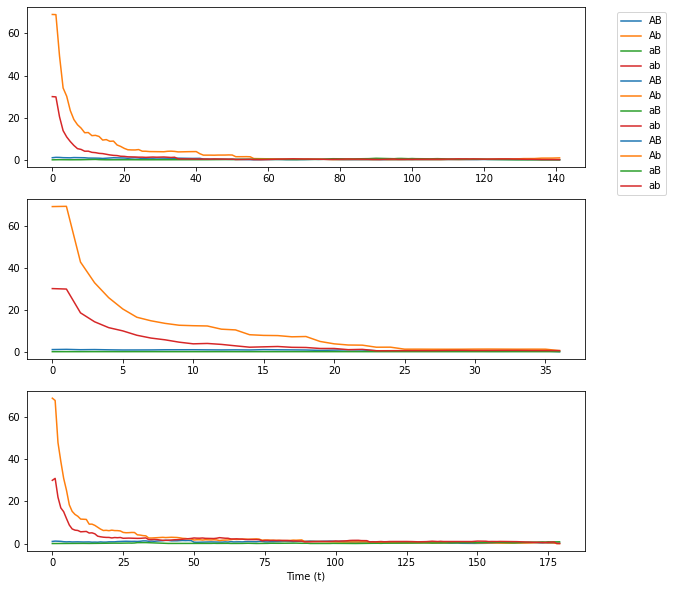

In [201]:
fig, axes = plt.subplots(3, figsize = (10, 10))

# Get list of the haplotype genotypes AB, Ab, aB and ab
all_haplotypes = list(initial_alleles.keys())

for i in range(len(r_value_colours.keys())):
    r_value = list(r_value_colours.keys())[i]
    
    for j in range(len(all_haplotypes)):
        haplotype = all_haplotypes[j]
        haplotype_freq = np.transpose(average_haplotype_freq[str(r_value)])[j]
        axes[i].plot(haplotype_freq, label = haplotype)
    
fig.legend(loc = "upper right", bbox_to_anchor = (1.02, 0.88))
plt.xlabel("Time (t)")
plt.show()